# Trabajo Práctico 1: Reservas de Hotel

<hr width="50%" align="left"/>

<br/>

# Clasificación - Entrenamiento y Predicción
## **Checkpoint 4 - "Redes Neuronales"**

<br/>

## **Grupo:** 03 - **_"Hackers Panas"_**

<br/>

## **Integrantes:**

<p>
<img align="left" src="https://github.com/NLGS2907.png" height=50 width=50 />

### [Franco Lighterman Reismann](https://github.com/NLGS2907) (106714)
<br/>
</p>

<p>
<img align="left" src="https://github.com/MarcosGN.png" height=50 width=50 />

### [Marcos García Neira](https://github.com/MarcosGN) (110363)
<br/>
</p>

<p>
<img align="left" src="https://github.com/mmaddalena.png" height=50 width=50 />

### [Martín Andrés Madalena](https://github.com/mmaddalena) (107610)
</p>

<br/><br/><br/><br/>
<hr/>

# **Instalaciones e _imports_ de librerías y otras dependencias.**

In [1]:
# No queremos ver la salida de pip
%%capture
# ---------- #

%pip install keras==2.12.0
%pip uninstall tensorflow -y
%pip install tensorflow==2.12.0

UsageError: Line magic function `%%capture` not found.


In [2]:
# Procesamiento de datos
import numpy as np
import pandas as pd

# Herramientas de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow / Keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

# sci-kit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score, make_scorer,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# type hinting
from typing import Any, Literal, Optional, TYPE_CHECKING, Union
if TYPE_CHECKING:
    from os import PathLike

# Otros
from IPython.display import display # preferible a print()
from pathlib import Path
from warnings import simplefilter
from google.colab import drive

simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)

In [3]:
# Va en una celda aparte para que no trate de montarlo cada vez que hay incluir nuevas librerías
drive.mount("/content/drive")

<hr/>

# **Preprocesamiento de Datos**

Primero importamos los datasets:

In [4]:
# train = pd.read_csv("../Datasets/hotels_train.csv")
# tests = pd.read_csv("../Datasets/hotels_test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_train.csv")
tests = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_test.csv")

In [5]:
# Variables de uso global
variables_categoricas = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel",
                         "is_repeated_guest", "reserved_room_type", "assigned_room_type", "deposit_type", "agent",
                         "company", "customer_type", "is_canceled"] # id no se deja a propósito
variables_cuantitativas = [categoria for categoria in train.columns if categoria not in variables_categoricas + ["id"]]

Y aplicamos, una vez más, loss tratamientos pertinentes a los datasets:

In [6]:
def tratamiento_train(df: pd.DataFrame,
                      *,
                      borrar_filas: bool=True,
                      borrar_columnas: bool=True,
                      imputaciones: bool=True) -> pd.DataFrame:
    """
    Realiza en forma rápida un resumen de todos los tratamientos explicados en el checkpoint 1
    a un DataFrame. Devuelve una copia sin afectar el original.
    -
    'borrar_filas': Si realizar los trabajos que borran filas o no.

    'borrar_columnas': Si realizar los trabajos que borran columnas o no.

    'imputaciones': Si realizar trabajos de imputaciones con el valor más frecuente.
    """

    df_copia = df.copy()

    # Eliminación de registros incompletos
    if borrar_columnas:
        df_copia = df_copia.drop(columns=["company"])

    if borrar_filas:
        df_copia = df_copia.dropna(axis="index", subset=["children", "country"])
    # ------------------------------ #

    # Imputación simple de datos
    if imputaciones:
        columnas_con_nulos = df.columns[df.isna().any()].tolist()
        imputador = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        datos_imputados = imputador.fit_transform(df_copia)
        df_imp = pd.DataFrame(data=datos_imputados,
                            index=df_copia.index,
                            columns=df_copia.columns)
        for col in columnas_con_nulos:
            if col in df_copia.columns: # que no llore si ya fue borrado
                df_copia[col] = df_imp[col]
        df_copia.reset_index(drop=True) # para hacer coincidir de nuevo los números del índice
    # ------------------------------ #

    # Creación de columnas personalizadas
    if "people" not in df_copia.columns:
        df_copia.insert(11, "people", (df_copia["adults"] + df_copia["children"] + df_copia["babies"]).astype(int))
    # ------------------------------ #

    # Conversión a enteros de columnas pertinentes
    for categoria in ["children", "agent"]:
        df_copia[categoria] = df_copia[categoria].astype(int)
    # ------------------------------ #

    # Valores Atípicos
    if borrar_filas:
        if df_copia["adr"][df_copia["adr"] <= 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adr"] <= 0].index, inplace=True)

        if df_copia["adults"][df_copia["adults"] == 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adults"] == 0].index, inplace=True)

        if df_copia["people"][df_copia["people"] > 5].count() != 0:
            df_copia.drop(df_copia[df_copia["people"] > 5].index, inplace=True)

        if df_copia[(df_copia["is_repeated_guest"] == 0) &
                    (df_copia["previous_bookings_not_canceled"] != 0)].shape[0] != 0:
            df_copia.drop(df_copia[(df_copia["is_repeated_guest"] == 0) &
                                   (df_copia["previous_bookings_not_canceled"] != 0)].index, inplace=True)
    # ------------------------------ #

    return df_copia

In [7]:
def reducir_columnas(df_reductor: pd.DataFrame, df_a_reducir: pd.DataFrame) -> pd.DataFrame:
    """
    Quita todas las columnas de 'df_a_reducir' que no estén presentes en 'df_reductor'.
    """

    categorias = df_a_reducir.columns.to_list() # hacemos una copia de la lista para no mutar mientras recorremos
    df_reducido = df_a_reducir.copy()

    for categoria in categorias:
        if categoria not in df_reductor.columns:
            df_reducido.drop(categoria, axis="columns", inplace=True)

    return df_reducido

In [8]:
df_chp4 = tratamiento_train(train)
df_tests = reducir_columnas(df_chp4, tests)

<hr/>

# **Creación de _Splits_**

In [9]:
def get_df_dummies(df: pd.DataFrame,
                   *,
                   variables_indeseadas: tuple[str, ...]=("company", "id", "is_canceled"),
                   metodo: Literal["ohe", "pd"]="ohe"
) -> pd.DataFrame:
    """
    Consigue una versión con dummies de un Dataframe, con reglas personalizadas.
    -
    'df': El DataFrame sobre el cual trabajar.

    'variables_indeseadas': Variables categóricas, pero que igual no deberían tenerse en cuenta
                            para el cálculo.

    'metodo': El método para generar los dummies:
                - 'ohe' utiliza `sklearn.preprocessing.OneHotEncoder()`
                - 'pd' utiliza `pandas.get_dummies()`
    """

    if metodo not in ("ohe", "pd"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'ohe' o 'pd'.")

    categorias = variables_categoricas.copy()
    for var in variables_indeseadas:
        if var in categorias:
            categorias.remove(var)

    if metodo == "ohe":
        ohe = OneHotEncoder(sparse_output=False, dtype=int).set_output(transform="pandas")
        return pd.concat([df.drop(categorias, axis="columns"), # df sólo con las cuantitativas
                          ohe.fit_transform(df[categorias])], # df con las cualitativas dummies
                         axis="columns")
    elif metodo == "pd":
        return pd.get_dummies(df, columns=categorias)

In [10]:
def split_in_axes(df: pd.DataFrame,
                  *,
                  x_innecesarias: tuple[str, ...]=("id", "is_canceled"),
                  target: Optional[str]=None
) -> pd.DataFrame:
    """
    Devuelve los ejes a entrenar/testear de un DataFrame.
    -
    'x_innecesarias': Qué columnas no incluir en el split del eje X.

    'target': La variable objetivo que terminará en el split del eje Y.
              El target también es eliminado, si se puede, del split del eje X.
    """

    if target is not None and target not in x_innecesarias:
        x_innecesarias.append(target)

    df_x = df.copy()
    for indeseada in x_innecesarias:
        if indeseada in df.columns:
            df_x = df_x.drop(indeseada, axis="columns", inplace=False)

    df_y = (None if target is None else df[target].copy())

    return df_x, df_y

Hacemos la función para optimizar hiperparámetros mediante _Cross Validation_:

In [11]:
def buscar_por_cv(*,
                  metodo: Literal["random", "grid"]="grid",
                  clasificador,
                  params_cv: dict[str, Any],
                  puntaje: Literal["accuracy", "recall", "precision", "f1"]="f1",

                  rand_comb: int=10,
                  folds: int=10,
                  kfold_estratificado: bool=True,
                  seed: Optional[int]=None) -> Union[RandomizedSearchCV, GridSearchCV]:
    """
    Realiza cross validation con parámetros dados.
    -
    'metodo': Con qué metodo realizar el trabajo:
              - 'random' es para utilizar `sklearn.model_selection.RandomizedSearchCV`
              - 'grid' es para utilizar `sklearn.model_selection.GridSearchCV`

    'clasificador': Un objeto estimador, ya inicializado: un árbol de decisión,
                    un clasificador KNN, etc.

    'params_cv': El diccionario de parámetros a probar en cada intento. Se asume que son compatibles
                 con el clasificador pasado.

    'puntaje': Método de puntaje:
               - 'accuracy' utiliza el Accuracy Score.
               - 'recall' utiliza el Recall Score.
               - 'precision' utiliza el Precision Score.
               - 'f1' utiliza el F1-Score.

    'rand_comb': Cantidad de combinaciones a probar si se elige el método 'random'.

    'folds': Cantidad de folds a usar en el KFold.

    'kfold_estratificado': Si utilizar `sklearn.model_selection.StratifiedKFold` o
                           `sklearn.model_selection.KFold`.

    'seed': La semilla para resultados determinísticos. Se usa sólo en el `RandomSearchCV()`.
            Si se desea una semilla para el clasificador, debe incluirse en 'params_cv'.
    """

    if metodo not in ("random", "grid"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'random' o 'grid'.")

    if puntaje not in ("accuracy", "recall", "precision", "f1"):
        raise ValueError(f"Argumento puntaje={puntaje} no válido, debe de ser 'accuracy', "
                         f"'recall', 'precision' o 'f1'.")

    # Kfold estratificado
    if kfold_estratificado:
        kfoldcv = StratifiedKFold(n_splits=folds)
    else:
        kfoldcv = KFold(n_splits=folds)

    # metricas
    posibles_metricas = {
        "accuracy": accuracy_score,
        "recall": recall_score,
        "precision": precision_score,
        "f1": f1_score
    }
    scorer_fn = make_scorer(posibles_metricas[puntaje])

    if metodo == "random": # Random Search Cross Validation
        return RandomizedSearchCV(estimator=clasificador,
                                  param_distributions=params_cv,
                                  scoring=scorer_fn,
                                  cv=kfoldcv,
                                  n_iter=rand_comb,
                                  n_jobs=-1,
                                  random_state=seed)

    if metodo == "grid": # Grid Search Cross Validation
        return GridSearchCV(estimator=clasificador,
                            param_grid=params_cv,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_jobs=-1,
                            return_train_score=True)

Y una función extra para mostrar las evaluaciones:

In [12]:
def evaluar(y_test: np.ndarray,
            y_pred: np.ndarray,
            *,
            seed_splits: Optional[int]=None,
            seed_modelo: Optional[int]=None,
            porcentaje_test: Optional[float]=None,
            mostrar_matriz: bool=True,
            titulo_matriz: Optional[str]=None) -> None:
    """
    Muestra los resultados de la performance en distintas métricas
    y además también la matriz de confunsión.
    -
    'y_test': La colección de datos a testear.

    'y_pred': La colección de predicciones a comparar con los datos de 'y_test'.

    'seed_splits'/'seed_modelo': Las semillas de generación pseudo-aleatoria para los splits
                                 train/tests y para el clasificador respectivamente.

    'porcentaje_test': Un float de `0.0` a `1.0`. Usado para calcular los splits de train/test.

    'mostrar_matriz': Si mostrar o no la matriz de confusión.

    'titulo_matriz': Si se dibuja la matriz, el título que aparecerá.
    """

    meta_info = []

    if seed_splits is not None:
        meta_info.append(f"Splits Seed:\t{seed_splits}")

    if seed_modelo is not None:
        meta_info.append(f"Model Seed:\t\t{seed_modelo}")

    if porcentaje_test is not None:
        meta_info.append(f"Train/Test:\t\t{100 - (porcentaje_test * 100)}% / "
                         f"{porcentaje_test * 100}%")

    if meta_info:
        meta_str = "\n".join(meta_info)
        print(f"{meta_str}\n-")

    print(f"Accuracy:\t\t{accuracy_score(y_test, y_pred)}\n"
          f"Recall:\t\t\t{recall_score(y_test, y_pred)}\n"
          f"Precision:\t\t{precision_score(y_test, y_pred)}\n"
          f"f1 score:\t\t{f1_score(y_test, y_pred)}\n\n")

    print(classification_report(y_test, y_pred))

    if mostrar_matriz:
        matriz_conf = confusion_matrix(y_test, y_pred)

        ax = sns.heatmap(matriz_conf, cmap="GnBu", annot=True, fmt="g")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        plt.title((titulo_matriz if titulo_matriz is not None else "Matriz de Confusión"))
        plt.show()

<hr width="30%" align="left" />

In [13]:
train_dummies = get_df_dummies(df_chp4)
train_dummies_x, train_dummies_y = split_in_axes(train_dummies, target="is_canceled")

semilla = 3
porcentaje_test = 0.2

sc = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(train_dummies_x,
                                                    train_dummies_y,
                                                    test_size=porcentaje_test,
                                                    stratify=train_dummies_y, # Acá en el Checkpoint 3 ya es importante estratificar
                                                    random_state=semilla)

x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)

<hr/>

# **Creación de Redes**

Es acá que creamos las redes neuronales.
Las métricas de puntaje, tal cual fueron explicadas con anterioridad, son las siguientes:

* **Accuracy:** La cantidad de **positivos y negativos predichos correctamente**, sobre el total de todos los datos. $\frac{TP + TN}{TP + TN + FP + FN}$
* **Recall:** La cantidad de **positivos predichos correctamente**, sobre todos los que _deberían ser positivos_ (los positivos correctamente predichos más los negativos mal predichos). $\frac{TP}{TP + FN}$
* **Precision:** La cantidad de **positivos predichos correctamente**, sobre todos los positivos (tanto los correctos como los mal predichos). $\frac{TP}{TP + FP}$
* **F1 Score:** Esta métrica se calcula con la media armónica de _Recall_ y _Precision_, por lo que ayuda a representar a ambas en una sola métrica. $\frac{2 \times Precision \times Recall}{Precision + Recall}$

<hr width="30%" align="left" />

In [14]:
def crear_red():
    """
    Crea y compila un red neuronal para ser usada más adelante.
    """

    d_in = len(x_train.columns)

    red = tf.keras.Sequential([
            tf.keras.layers.Dense(1000, input_dim=d_in, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="sigmoid"),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ]
    )

    red.compile(
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["AUC"],
    )

    return red

Luego, a entrenarlo y generar predicciones:

In [15]:
# # ----- Buscado por CV -----
# parametros_cv_red = {
#     "epochs": np.arange(90, 170),
#     "batch_size": np.arange(10, 60),
#     "verbose": [False]
# }
# cv_red = buscar_por_cv(metodo="random",
#                        clasificador=KerasClassifier(build_fn=crear_red),
#                        params_cv=parametros_cv_red,
#                        puntaje="f1",
#                        rand_comb=10,
#                        folds=10,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_red.fit(X=x_train, y=y_train)

# print(f"{cv_red.best_params_}\n"
#       f"{cv_red.best_score_}")
# red = cv_red.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
red = crear_red()
red.summary()
red.fit(x_train_norm, y_train,
        epochs=500, batch_size=100, verbose=False)
# ------------------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              519000    
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 624,201
Trainable params: 624,201
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_pred_red = red.predict(x_test_norm)
y_pred_red_round = np.round(y_pred_red).astype(int)

378/378 [==============================] - 1s 3ms/step


Finalmente, evaluamos la red neuronal que entrenamos:

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.857272802447697
Recall:			0.8623838252078917
Precision:		0.8570734078755469
f1 score:		0.8597204161248374


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5960
           1       0.86      0.86      0.86      6133

    accuracy                           0.86     12093
   macro avg       0.86      0.86      0.86     12093
weighted avg       0.86      0.86      0.86     12093



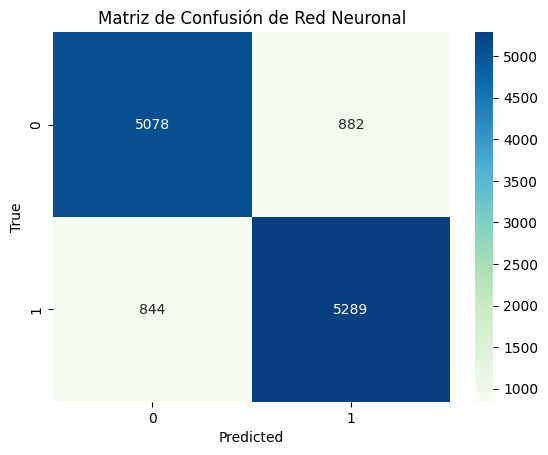

In [17]:
evaluar(y_test, y_pred_red_round,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Red Neuronal")

<hr/>

# **Exportando Predicciones**

In [18]:
def alinear_df_test(df_train: pd.DataFrame, df_test: pd.DataFrame,
                    *,
                    vacio: Union[int, float]=0
) -> pd.DataFrame:
    """
    Esta función hace dos cosas:
        - Crea toda columna presente en 'df_train' (pero no en 'df_test') como una columna nueva
          en 'df_test' y las rellena con el valor 'vacio'.
        - Elimina toda columna que esté en 'df_test' pero no en 'df_train'.

    Se presupone que ambos DataFrames vienen sólo con valores numéricos; normalmente fueron
    convertidos a DataFrames con dummies.
    -
    'df_train': El DataFrame con el que se entrenó el modelo.

    'df_test': El DataFrame con los datos a predecir.

    'vacio': El valor con el que rellenar las columnas insertadas en 'df_test'. Normalmente es `0`,
             pues es el valor que se usa en One Hot Encoding para designar que NO es esa variable.
    """

    df_test_convertida = reducir_columnas(df_train, df_test)

    for col in df_train.columns:
        if col not in df_test.columns:
            nueva_col = np.array([0] * df_test.shape[0]).reshape(-1, 1)
            df_test_convertida[col] = nueva_col

    return df_test_convertida[df_train.columns] # reordenar las columnas con el mismo orden

In [19]:
def generar_predicciones(train_dummies: pd.DataFrame, df_test: pd.DataFrame,
                         *,
                         modelo,
                         normalizar_splits: bool=False,
                         escalador: Literal["std", "minmax"]="std") -> np.ndarray:
    """
    Toma un dataset de entrenamiento pertinente, y el dataset de testeo, y genera las predicciones
    para ese modelo.
    -
    'train_dummies': El dataset de entrenamiento, ya con sus dummies.

    'df_test': El dataset de testeo.

    'modelo': El modelo de predicción, ya entrenado.

    'normalizar_splits': Los splits, donde sea posible, serán normalizados con un escalador.

    'escalador': El escalador con el que normalizar los splits:
                 - 'std' utiliza `sklearn.preprocessing.StandardScaler`.
                 - 'minmax' utiliza `sklearn.preprocessing.MinMaxScaler`.
    """

    if escalador not in ("std", "minmax"):
        raise ValueError(f"Argumento escalador='{escalador}' no válido. Debe ser 'std' o 'minmax'.")

    tests_dummies_desalineados = get_df_dummies(df_test).rename(columns=(lambda col : (col.removesuffix(".0") if col.endswith(".0") else col)))

    test_dummies = alinear_df_test(train_dummies, tests_dummies_desalineados)
    test_x, _ = split_in_axes(test_dummies)

    if normalizar_splits:
        if escalador == "std":
            scaler = StandardScaler()
        elif escalador == "minmax":
            scaler = MinMaxScaler()

        x_a_predecir = scaler.fit_transform(test_x)

    else:
        x_a_predecir = test_x

    return modelo.predict(x_a_predecir)

In [20]:
def exportar_predicciones(df_test: pd.DataFrame, predicciones: np.ndarray,
                          *,
                          target: str="is_canceled",
                          nombre: "PathLike", # Más bien que se parezca a un nombre de archivo con extensión
                          ruta: "PathLike"="./drive/MyDrive/Colab Notebooks/predictions") -> None:
    """
    Intenta guardar las predicciones en una ruta en Google Drive, para uso interno. Normalmente
    como forma temporal para después subirlo a kaggle.
    Se presupone que el drive ya fue montado junto con los imports.
    -
    'df_test': El DataFrame de los datos a predecir. De acá sacamos la columna 'id'.

    'predicciones': Un `numpy.ndarray` (o lo que salga de `model.predict()`). Estos son los valores
                    que han de llenar la columna del target.

    'target': El nombre de la columna del target. A efectos de este TP1 siempre debería
              ser `"is_canceled"`.

    'nombre': El nombre del archivo en cuestión, de formato `.csv`. Ejemplo: `"predicted1.csv"`.

    'ruta': Ruta del directorio en Drive donde el archivo será guardado.
    """

    path = Path(ruta) / nombre
    df_a_exportar = pd.DataFrame()

    df_a_exportar["id"] = df_test["id"]
    df_a_exportar[target] = predicciones.reshape(-1, 1)

    df_a_exportar.to_csv(path, index=False)

In [21]:
predicciones = np.round(generar_predicciones(train_dummies, tests, modelo=red,
                                             normalizar_splits=True, escalador="std")).astype(int)
# exportar_predicciones(tests, predicciones,
#                       nombre="predicciones_rn.csv")

830/830 [==============================] - 3s 3ms/step
